<H1>Stratégie Envelope</H1>
Indicateurs: Envelope + SMA<br>
SEG

In [1]:
# Modules standards
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# Modules perso
from utilities.strategies import SaEnvelope
from utilities.data_manager import ExchangeDataManager
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, plot_bar_by_month
from utilities.futur_simulations import plot_futur_simulations, plot_train_test_simulation

In [40]:
# Chargement de data dans un dataframe
exchange_name = "binance"
pair = "ETH/USDT"
coin = pair.split('/')[0]
tf = "1h"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(
    coin=pair, 
    interval=tf
)

d:\Python\Cryptobots\backtest_tools\backtest\single_coin\../..\utilities\data_manager.py:116: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



<H2>Backtest</H2>

╒═════════════════════════════╤══════════════════════════════════════╕
│ Résultats backtest          │ ETH/USDT(1h)                         │
╞═════════════════════════════╪══════════════════════════════════════╡
│ Période                     │ 02.01.2019 -> 11.01.2024             │
│ Portefeuille initial        │ 1,000.00 $                           │
│                             │                                      │
│ Portefeuille final          │ 12,692.50 $                          │
│ Performance vs US dollar    │ 1,169.25 %                           │
│ Pire Drawdown T|D           │ -18.64% | -25.33%                    │
│ Buy and hold performance    │ 1776.21 %                            │
│ Performance vs buy and hold │ -32.35 %                             │
│ Nombre total de trades      │ 174                                  │
│ Sharpe Ratio                │ 1.87                                 │
│ Global Win rate             │ 80.46 %                              │
│ Prof

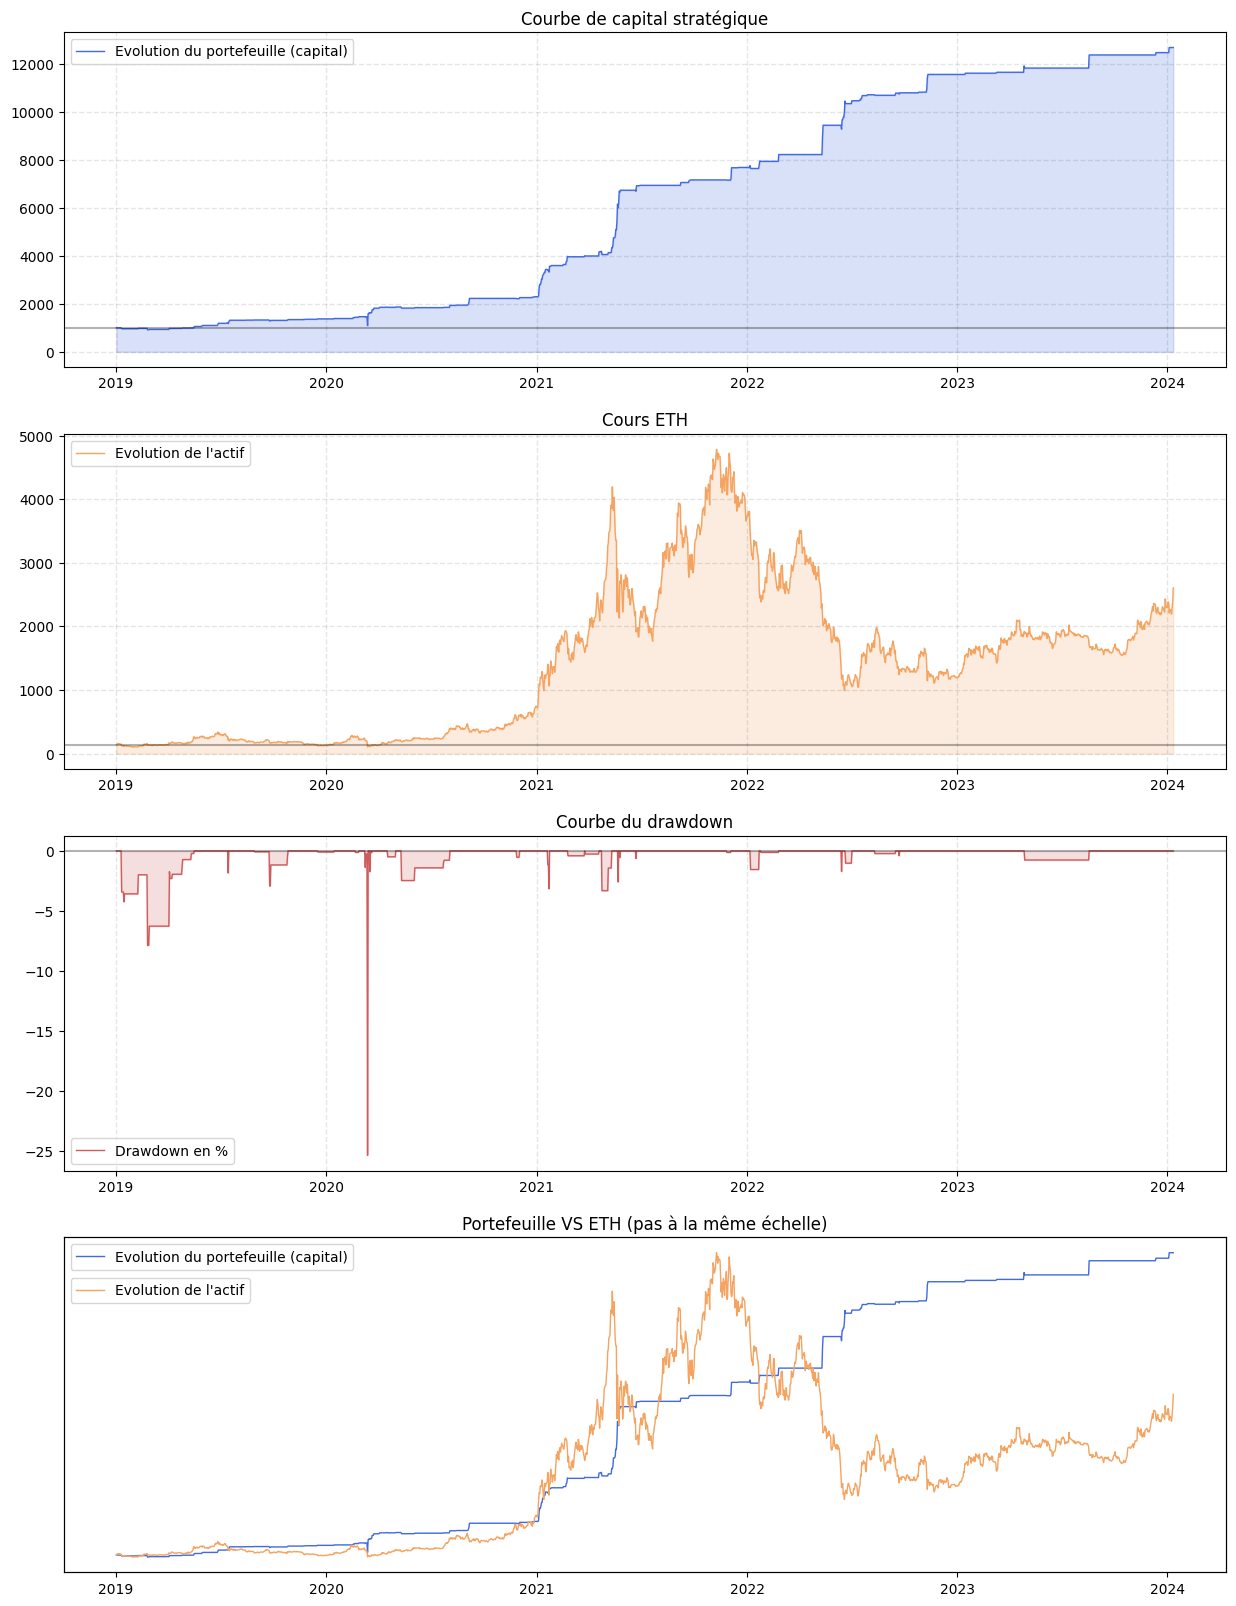

In [41]:
# Paramètres à modifier pour le backtest
# strat = SaEnvelope( # BTC
#     df = df.loc["2019":],
#     type=["long", "short"],
#     ma_base_window=7,
#     envelopes=[0.07, 0.1, 0.15],
#     src="close",
# )
strat = SaEnvelope( # ETH
    df = df.loc["2019-01-02":],
    type=["long", "short"],
    ma_base_window=6,
    envelopes=[0.07, 0.09, 0.11],
    src="close",
)
# strat = SaEnvelope( # ADA EGLD
#     df = df.loc["2019":],
#     type=["long", "short"],
#     ma_base_window=8,
#     envelopes=[0.06, 0.07, 0.08, 0.1],
#     src="close",
# )
# strat = SaEnvelope( # KSM OCEAN REN BAR
#     df = df.loc["2019":],
#     type=["long", "short"],
#     ma_base_window=5,
#     envelopes=[0.07, 0.1, 0.15, 0.2],
#     src="close",
# )

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'], pair=pair, tf=tf)
plot_wallet_vs_asset(df_days=df_days, pair=pair)

<H2>Performance par mois et année</H2>

----- 2019 Performances cumulées: 37.43% --


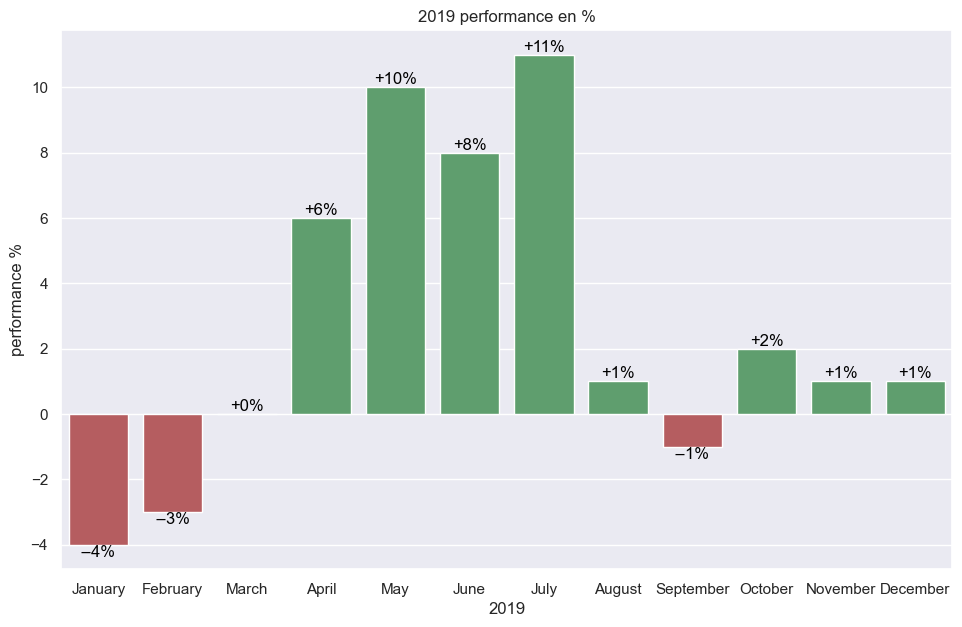

----- 2020 Performances cumulées: 67.26% --


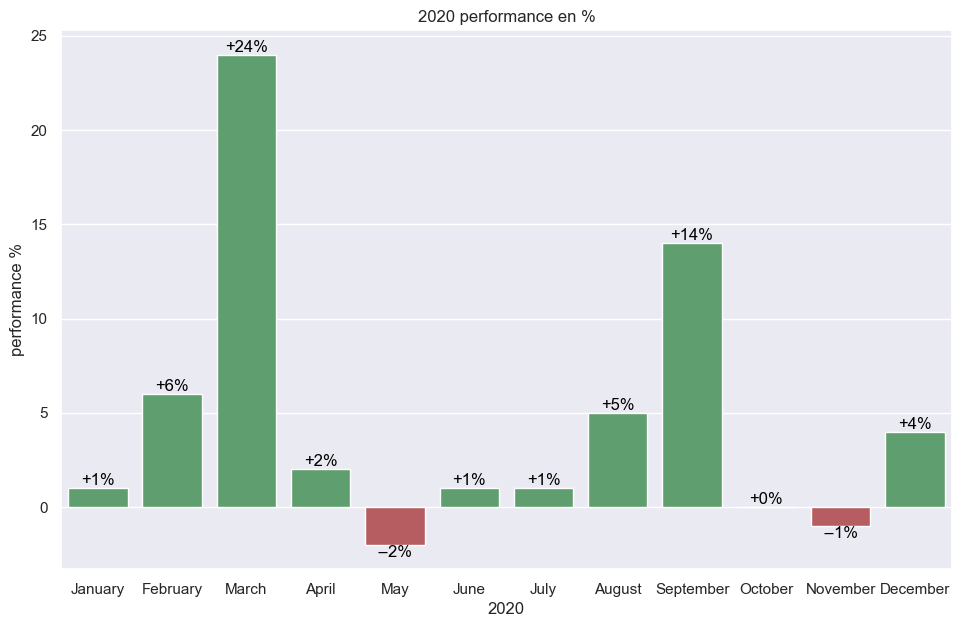

----- 2021 Performances cumulées: 234.58% --


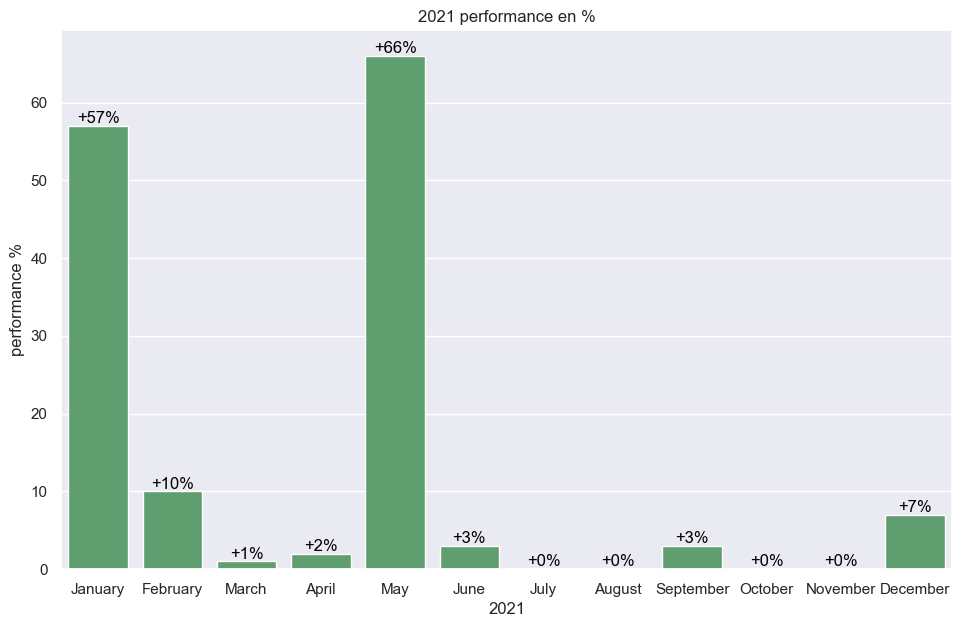

----- 2022 Performances cumulées: 50.44% --


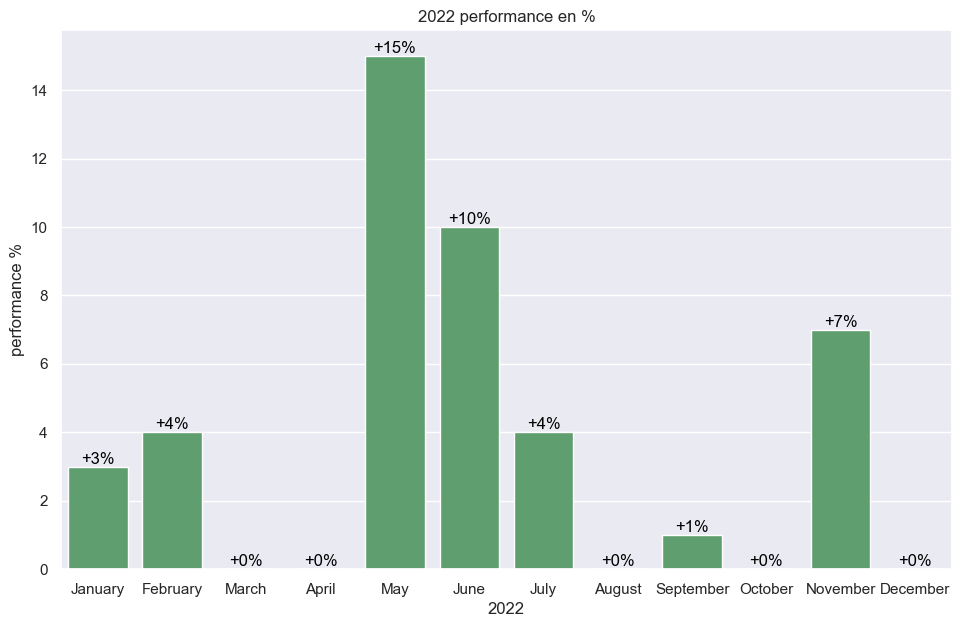

----- 2023 Performances cumulées: 7.87% --


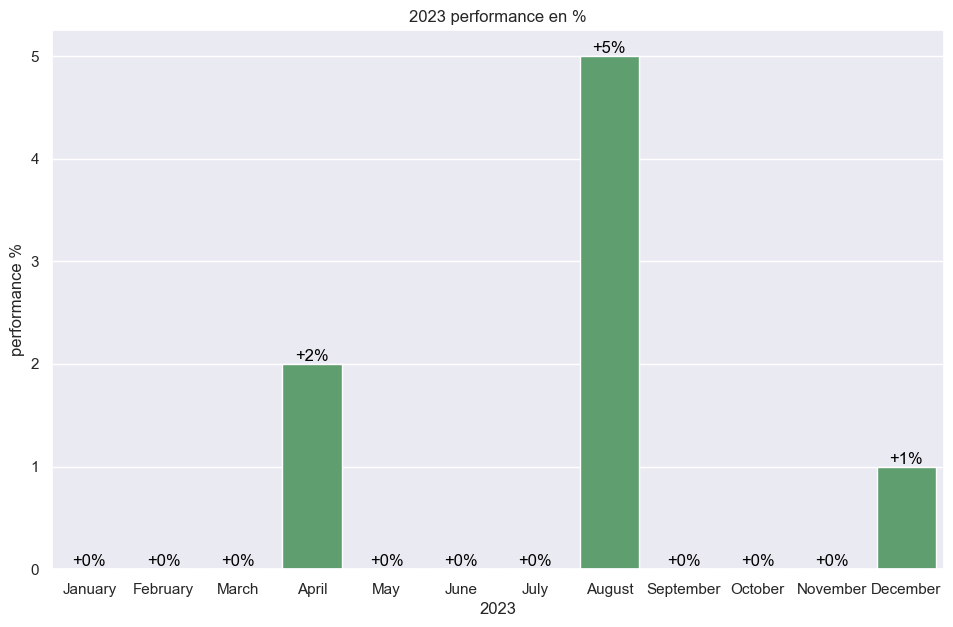

----- 2024 Performances cumulées: 1.7% --


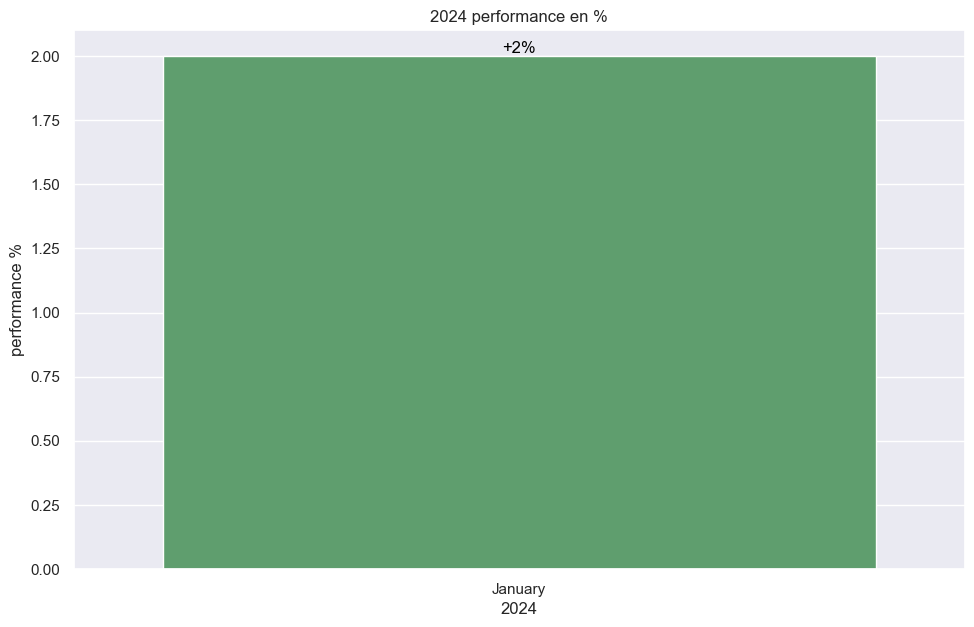

In [42]:
plot_bar_by_month(df_days)

<H2>Courbe de surapprentissage</H2>

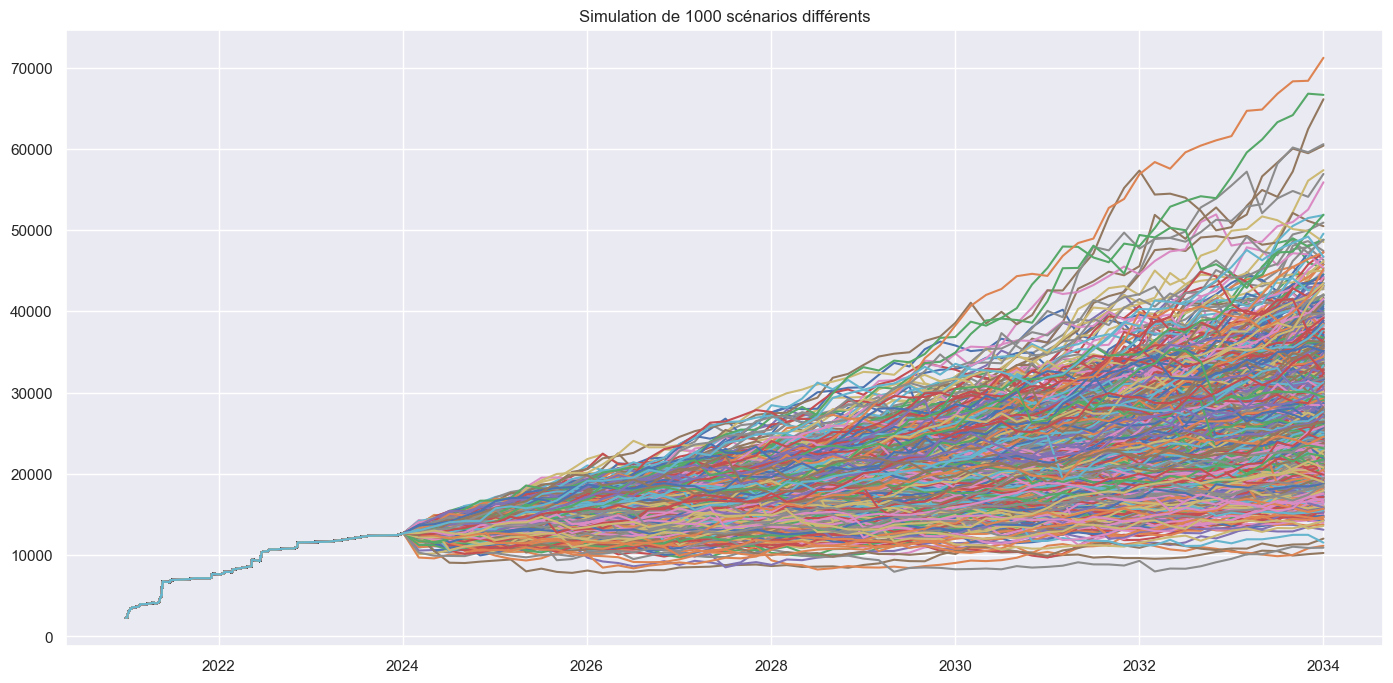

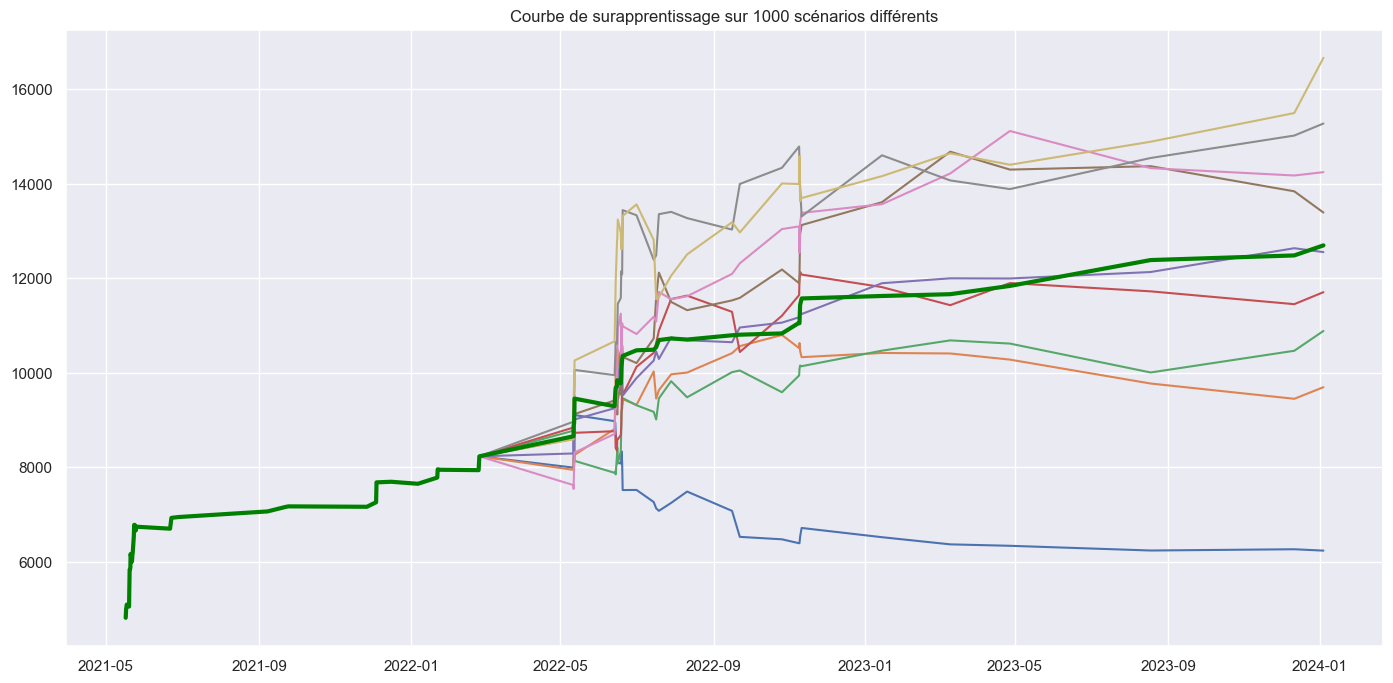

In [43]:
# Simulation de divers scénarios futurs
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=60,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=True
)

# Comparaison entre les divers scénarios et la réalité pour voir si il y a du surapprentissage
# Séparation des échantillons en train et en test - Méthode de Monte Carlo (Loi normale)
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-05-01",
    trades_multiplier=3,
    number_of_simulations=1000,
)

<H2>Optimisation des paramètres</H2>

In [44]:
# A déclarer avant l'optimisation pour avoir les graphiques sans avoir à lancer le module Hyperopt
from typing import List
import numpy as np
from hyperopt import hp

range_envelope_1 = np.arange(0.03, 0.11, 0.01)
range_envelope_1 = [round(val, 2) for val in range_envelope_1]
range_envelope_2 = np.arange(0.05, 0.12, 0.01)
range_envelope_2 = [round(val, 2) for val in range_envelope_2]
range_envelope_3 = np.arange(0.06, 0.15, 0.01)
range_envelope_3 = [round(val, 2) for val in range_envelope_3]
range_envelope_4 = np.arange(0.08, 0.2, 0.01)
range_envelope_4 = [round(val, 2) for val in range_envelope_4]

# Espace de recherche des hyperparamètres avec contraintes
index_np_arrange =4
space = {
    'ma_base_window': hp.choice('ma_base_window', np.arange(index_np_arrange, 10, dtype=int)),  # 4 à 9
    'envelopes': [
        hp.choice('envelope_1', range_envelope_1),                                              # 0.03 à 0.1
        hp.choice('envelope_2', range_envelope_2),                                              # 0.05 à 0.12
        hp.choice('envelope_3', range_envelope_3),                                              # 0.07 à 0.15
        hp.choice('envelope_4', range_envelope_4),                                              # 0.09 à 0.2
    ],
}

In [45]:
# Hyperopt
from hyperopt import fmin, Trials, tpe
from concurrent.futures import ThreadPoolExecutor
import pickle

def objective(params):
    ma_base_window = int(params['ma_base_window'])
    envelopes = params['envelopes']

    strat = SaEnvelope(
        df=df.loc["2019":],
        type=["long", "short"],
        ma_base_window=ma_base_window,
        envelopes=envelopes,
        src="close",
    )

    strat.populate_indicators()
    strat.populate_buy_sell()
    bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

    # Métriques à optimiser
    wallet_metric = bt_result["wallet"]
    sharpe_ratio_metric = bt_result["sharpe_ratio"]
    weight_wallet = 0.7         # Poids pour le wallet final
    weight_sharpe_ratio = 0.3   # Poids pour le Sharpe Ratio

    # Fonction de perte combinée
    combined_loss = -(weight_wallet * wallet_metric + weight_sharpe_ratio * sharpe_ratio_metric)

    return combined_loss

max_evals = 500  # max_evals=5 pour test rapide.
with ThreadPoolExecutor() as executor:
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)    

# Sauvegarde des résultats dans un fichier pickle
if max_evals >= 50:
    with open('hyperopt/'+ coin + '_' + str(max_evals) + '_envelope.pkl', 'wb') as f:
        pickle.dump(trials, f)

# Afficher les meilleurs hyperparamètres trouvés
best_ma_base_window = best['ma_base_window'] + index_np_arrange
best_envelopes_indices = [best['envelope_1'], best['envelope_2'], best['envelope_3'], best['envelope_4']]
best_envelopes_values = [
        range_envelope_1[best_envelopes_indices[0]],
        range_envelope_2[best_envelopes_indices[1]],
        range_envelope_3[best_envelopes_indices[2]],
        range_envelope_4[best_envelopes_indices[3]],
]

print(f"Best ma_base_window: {best_ma_base_window}")
print(f"Best envelopes: {best_envelopes_values}")

100%|██████████| 500/500 [07:47<00:00,  1.07trial/s, best loss: -15743.968593293335]
Best ma_base_window: 6
Best envelopes: [0.08, 0.08, 0.09, 0.09]


In [46]:
# Backtest rapide avec les meilleures paramètres
import pickle

file_pkl = 'hyperopt/'+ coin + '_' + str(max_evals) + '_envelope.pkl'
# file_pkl = 'hyperopt/BTC_1000_envelope.pkl'

with open(file_pkl, 'rb') as f:
    trials = pickle.load(f)

index_np_arrange =4
best_trial = min(trials, key=lambda x: x['result']['loss'])
best_hyperparams = best_trial['misc']['vals']
best_ma_base_window = int(best_hyperparams['ma_base_window'][0]) + index_np_arrange
best_envelopes_indices = [int(best_hyperparams['envelope_1'][0]), int(best_hyperparams['envelope_2'][0]), int(best_hyperparams['envelope_3'][0]), int(best_hyperparams['envelope_4'][0])]
best_envelopes = [
    range_envelope_1[best_envelopes_indices[0]],
    range_envelope_2[best_envelopes_indices[1]],
    range_envelope_3[best_envelopes_indices[2]],
    range_envelope_4[best_envelopes_indices[3]],
]

# Utiliser les meilleurs paramètres pour obtenir le résultat final
best_strat = SaEnvelope(
    df=df.loc["2019":],
    type=["long", "short"],
    ma_base_window=best_ma_base_window,
    envelopes=best_envelopes,
    src="close",
)

best_strat.populate_indicators()
best_strat.populate_buy_sell()
best_result = best_strat.run_backtest(initial_wallet=1000, leverage=1)

# Afficher le wallet et le sharpe_ratio des meilleures paramètres
print(f"Pair:                 {pair}")
print(f"Best ma_base_window:  {best_ma_base_window}")
print(f"Best envelopes:       {best_envelopes}")
print(f"Best Wallet:          {best_result['wallet']}")
print(f"Best Sharpe ratio:    {best_result['sharpe_ratio']}")

Pair:                 ETH/USDT
Best ma_base_window:  6
Best envelopes:       [0.08, 0.08, 0.09, 0.09]
Best Wallet:          22490.59766688411
Best Sharpe ratio:    1.8340882481984195


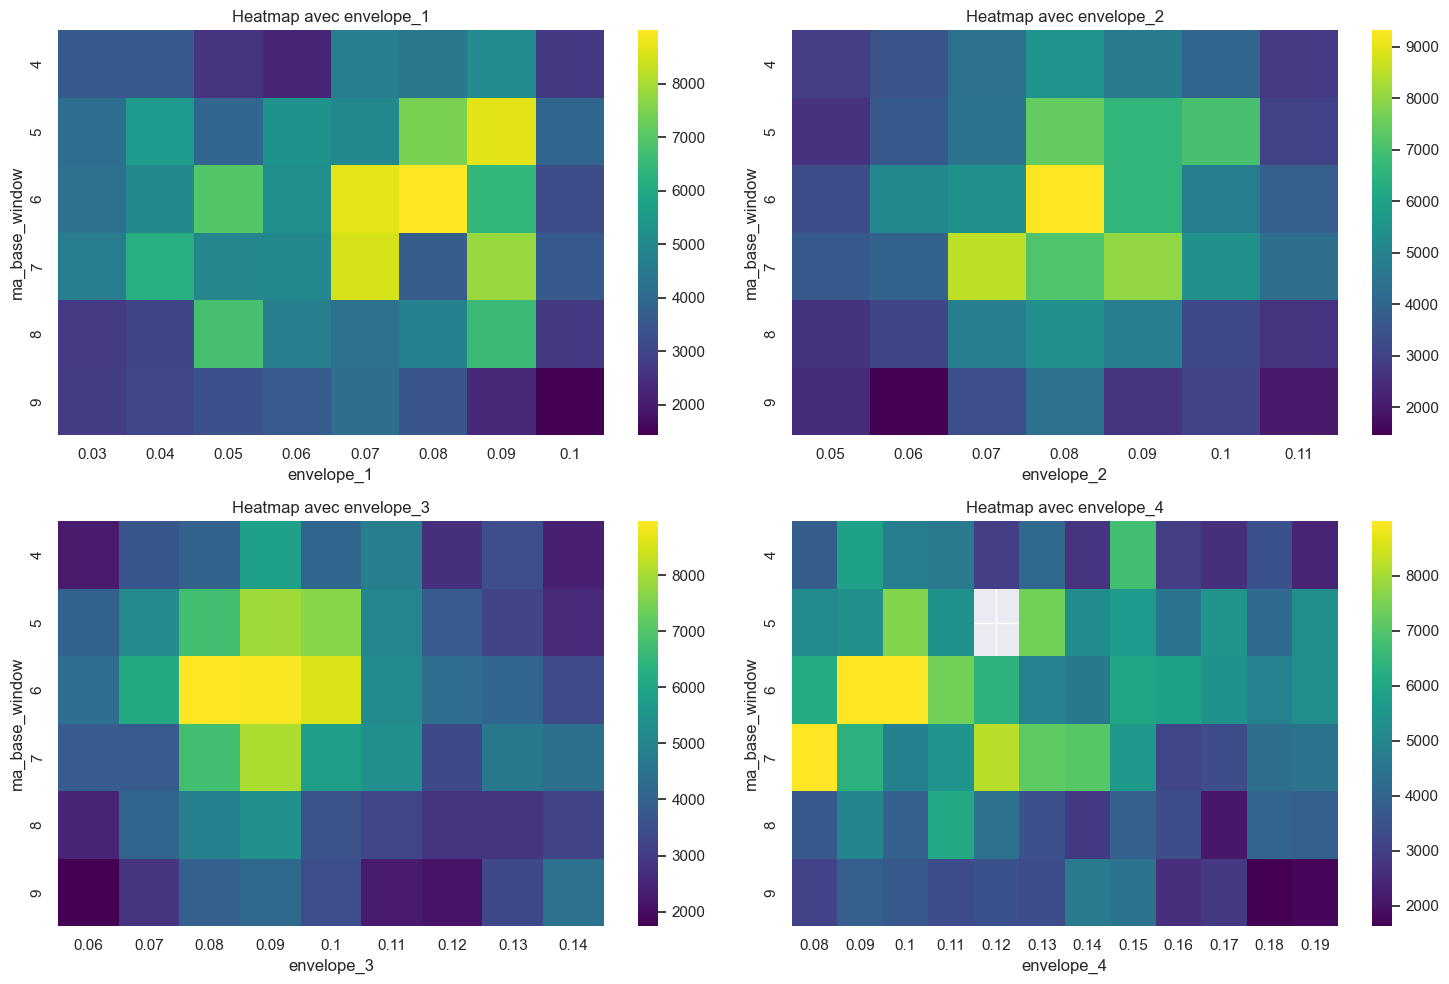

In [47]:
# Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Extraire les informations des Trials
results_df = pd.DataFrame({
    'ma_base_window': [int(trial['misc']['vals']['ma_base_window'][0]) + index_np_arrange for trial in trials.trials],
    'envelope_1': [trial['misc']['vals']['envelope_1'][0] for trial in trials.trials],
    'envelope_2': [trial['misc']['vals']['envelope_2'][0] for trial in trials.trials],
    'envelope_3': [trial['misc']['vals']['envelope_3'][0] for trial in trials.trials],
    'envelope_4': [trial['misc']['vals']['envelope_4'][0] for trial in trials.trials],
    'score': [-trial['result']['loss'] for trial in trials.trials]
})

# Convertir les indices des enveloppes en valeurs réelles
results_df['envelope_1'] = results_df['envelope_1'].apply(lambda idx: range_envelope_1[idx])
results_df['envelope_2'] = results_df['envelope_2'].apply(lambda idx: range_envelope_2[idx])
results_df['envelope_3'] = results_df['envelope_3'].apply(lambda idx: range_envelope_3[idx])
results_df['envelope_4'] = results_df['envelope_4'].apply(lambda idx: range_envelope_4[idx])

# Créer une figure avec une grille de sous-graphiques (2 lignes, 2 colonnes)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Liste des enveloppes
envelopes = ['envelope_1', 'envelope_2', 'envelope_3', 'envelope_4']

# Tracer une heatmap par enveloppe
for i, envelope in enumerate(envelopes):
    pivot_table = results_df.pivot_table(index='ma_base_window', columns=envelope, values='score', aggfunc='mean')
    sns.heatmap(pivot_table, annot=False, fmt=".2f", cmap="viridis", ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Heatmap avec {envelope}')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


In [48]:
# Exploration 3D
import plotly.express as px

# Extraire les informations des Trials
results_df = pd.DataFrame({
    'ma_base_window': [trial['misc']['vals']['ma_base_window'][0] + index_np_arrange for trial in trials.trials],
    'envelope_1': [round(trial['misc']['vals']['envelope_1'][0], 2) for trial in trials.trials],
    'envelope_2': [round(trial['misc']['vals']['envelope_2'][0], 2) for trial in trials.trials],
    'envelope_3': [round(trial['misc']['vals']['envelope_3'][0], 2) for trial in trials.trials],
    'envelope_4': [round(trial['misc']['vals']['envelope_4'][0], 2) for trial in trials.trials],
    'score': [-trial['result']['loss'] for trial in trials.trials]
})

# Convertir les indices des enveloppes en valeurs réelles
results_df['envelope_1'] = results_df['envelope_1'].apply(lambda idx: range_envelope_1[idx])
results_df['envelope_2'] = results_df['envelope_2'].apply(lambda idx: range_envelope_2[idx])
results_df['envelope_3'] = results_df['envelope_3'].apply(lambda idx: range_envelope_3[idx])
results_df['envelope_4'] = results_df['envelope_4'].apply(lambda idx: range_envelope_4[idx])

# Créer une heatmap interactive avec Plotly
fig = px.scatter_3d(results_df,
                    x='envelope_1',
                    y='envelope_2',
                    z='envelope_3',
                    color='score',
                    size='ma_base_window',
                    labels={'envelope_1': 'Envelope 1', 'envelope_2': 'Envelope 2', 'envelope_3': 'Envelope 3', 'envelope_4': 'Envelope 4'},
                    title='Optimisation des Paramètres',
                    opacity=0.7,
                    hover_name='score')

# Augmenter la hauteur de la heatmap
fig.update_layout(scene=dict(aspectmode='data'),
                  margin=dict(r=0, l=0, b=0, t=0),
                  height=600, width=1000 )

# Afficher la figure interactive
fig.show()


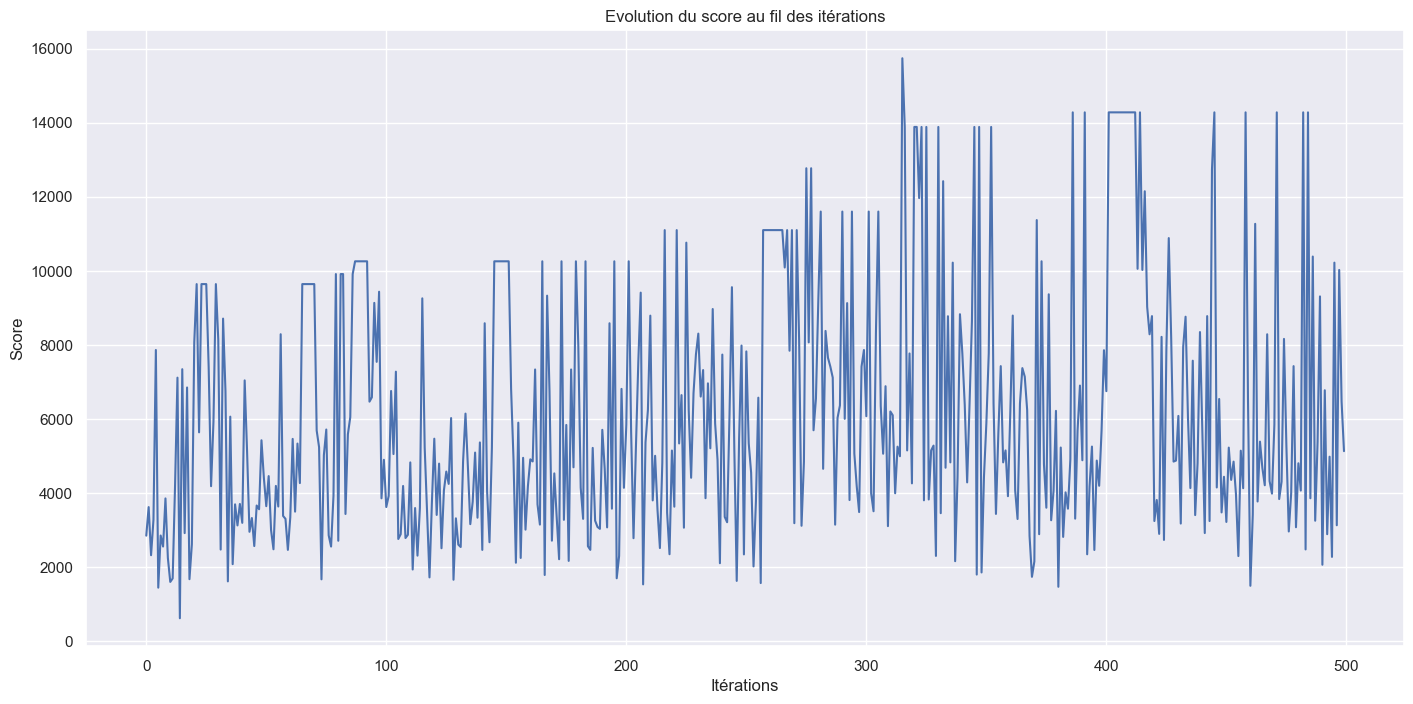

In [49]:
# Evolution du score au fil des itérations
import matplotlib.pyplot as plt

# Récupérer les résultats des évaluations
results = [-trial['result']['loss'] for trial in trials.trials]

# Afficher l'évolution des scores au fil des itérations
plt.plot(results)
plt.xlabel('Itérations')
plt.ylabel('Score')
plt.title('Evolution du score au fil des itérations')
plt.show()

Perte minimale:  622.1600832560077
Pertes au fil des évaluations: [2852.7396969571423, 3623.654109634853, 2324.5348129847084, 3281.3562443669325, 7865.793064420861, 1448.2030061266369, 2855.9645668409294, 2558.8805804397284, 3857.867161479009, 2251.521172258346, 1603.2478621640912, 1696.9679491506163, 4216.936232318104, 7118.659094773019, 622.1600832560077, 7347.331404479464, 2921.227259717265, 6853.603357175736, 1677.2016301801661, 2620.0301263155748, 8076.195273928188, 9645.484098210698, 5642.521860945438, 9645.484098210698, 9645.484098210698, 9645.484098210698, 7404.861456811015, 4188.3288590041075, 5934.712756335277, 9645.484098210698, 8141.9530526014705, 2477.090895070278, 8713.543818929296, 6754.791722483363, 1617.9160020753866, 6066.114111750544, 2082.4350010706107, 3697.9442679545373, 3128.8833104433324, 3708.2264152760013, 3198.481627286955, 7045.317513757995, 5129.141708448039, 2956.9942335048536, 3328.0001454492854, 2571.7592645193804, 3666.2497907960524, 3565.804572159926, 

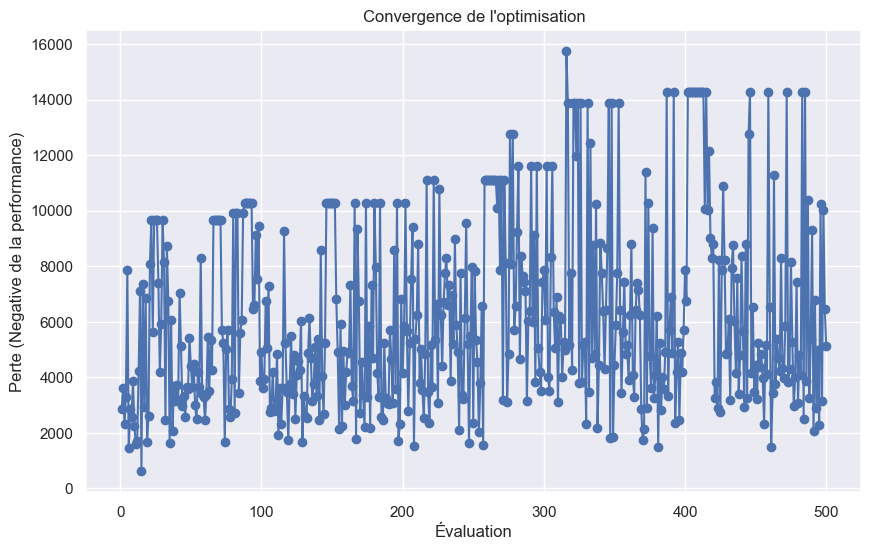

In [50]:
# Extraire les performances au fil des évaluations
losses = [-trial.get('result', {}).get('loss', None) for trial in trials.trials]
print("Perte minimale: ", np.min(losses))

# Créer le DataFrame de convergence
convergence_df = pd.DataFrame({
    'Evaluation': range(1, len(losses) + 1),
    'Perte': losses
})
# Afficher les pertes au fil des évaluations
print("Pertes au fil des évaluations:", losses)

# Afficher le graphique de convergence
plt.figure(figsize=(10, 6))
plt.plot(convergence_df['Evaluation'], convergence_df['Perte'], marker='o', linestyle='-', color='b')
plt.title('Convergence de l\'optimisation')
plt.xlabel('Évaluation')
plt.ylabel('Perte (Negative de la performance)')
plt.show()

In [ ]:
# Méthode classique par boucle (A terminer et a commenter)
import itertools
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time

start_time = time.time()

ma_base_window_values = list(range(3, 7))
envelopes_values = [
    [round(val1, 3), round(val2, 3), round(val3, 3)] 
    for val1, val2, val3 in itertools.product(
        [i * 0.02 for i in range(2, 8)], 
        [i * 0.02 for i in range(8, 14)], 
        [i * 0.02 for i in range(14, 20)]
    )
]

with ThreadPoolExecutor() as executor:
    def run_backtest(params):
        ma_base_window, envelopes = params
        current_strat = SaEnvelope(
            df=df.loc["2019-01-02":],
            type=["long", "short"],
            ma_base_window=ma_base_window,
            envelopes=envelopes,
            src="close",
        )

        current_strat.populate_indicators()
        current_strat.populate_buy_sell()
        current_result = current_strat.run_backtest(initial_wallet=1000, leverage=1)
        return {'params': {'ma_base_window': ma_base_window, 'envelopes': envelopes}, 'result': current_result}

    results = list(tqdm(executor.map(run_backtest, itertools.product(ma_base_window_values, envelopes_values)), total=len(ma_base_window_values)*len(envelopes_values)))

best_result = max(results, key=lambda x: x['result']['wallet'])

print("Best Parameters:", best_result['params'])
print("Best Performance (Final Wallet Value):", best_result['result']['wallet'])
print("Sharpe Ratio: ", best_result['result']['sharpe_ratio'])
end_time = time.time()
elapsed_time = end_time - start_time
print("Temps de calcul total:", elapsed_time, "secondes")